<b>Exercise 1: Sentinel Images</b>

1. Write a function that takes a lat-lon pair and a time interval as input and returns a
400mx400m RGB image centered at (lat, lon) taken on the given time interval extracted
from the SentinelHub API. Use the Sentinel-2 satellite and make sure that the image
selected is the one with least cloud coverage.

Test the functions with a corn field of your choice. You can find the location of agricultural fields
on OneSoil, for example.

<i><b>IMPORT SECTION</b></i>

In [28]:
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
import utils

from sentinelhub import MimeType, SHConfig, CRS, BBox, SentinelHubRequest, SentinelHubDownloadClient, \
    DataCollection, bbox_to_dimensions, DownloadRequest

<i><b>CONFIGURATION SECTION</b></i>

In [29]:
config = SHConfig()
config.instance_id = 'c156dc38-84e6-4e95-8c36-73de5637636a'
config.sh_client_id = 'e1a9bfc8-e283-4adf-971d-2c3d71787d9c'
config.sh_client_secret = 'B@DS2;sB8,k!qeGrXkxa?Rr3zC3bUt,M[a+7l5qf'

if config.sh_client_id == '' or config.sh_client_secret == '':
    print("Warning! To use Sentinel Hub Process API, please provide the credentials (client ID and client secret).")

config.save()


<i><b>FUNCTIONS SECTION</b></i>

In [30]:
def square_from_point(center_longitude, center_latitude, side_length):
    from math import sqrt,atan,pi
    import pyproj
    
    square_coodrinate_points = {}
    geod = pyproj.Geod(ellps='WGS84')
    
    width = height = side_length#in meters
    diagonal = sqrt( width**2 + height**2 )

    #the azimuth is calculated by using the aspect ratio of the square.
    azimuth_1 = atan(width/height)
    azimuth_2 = atan(-width/height)
    azimuth_3 = atan(width/height)+pi #first point + 180 degrees
    azimuth_4 = atan(-width/height)+pi #second point + 180 degrees

    point_1_longitude, point_1_latitude, back_azimuth = geod.fwd(center_longitude, center_latitude, azimuth_1*180/pi, diagonal)
    point_2_longitude, point_2_latitude, back_azimuth = geod.fwd(center_longitude, center_latitude, azimuth_2*180/pi, diagonal)
    point_3_longitude, point_3_latitude, back_azimuth = geod.fwd(center_longitude, center_latitude, azimuth_3*180/pi, diagonal)
    point_4_longitude, point_4_latitude, back_azimuth = geod.fwd(center_longitude, center_latitude, azimuth_4*180/pi, diagonal)

    square_coodrinate_points = {
        'point_1_longitude': point_1_longitude,
        'point_1_latitude': point_1_latitude,
        'point_2_longitude': point_2_longitude,
        'point_2_latitude': point_2_latitude,
        'point_3_longitude': point_3_longitude,
        'point_3_latitude': point_3_latitude,
        'point_4_longitude': point_4_longitude,
        'point_4_latitude': point_4_latitude
    }
    
    return square_coodrinate_points 

def plot_image(image, factor=1.0, clip_range = None, **kwargs):
    """
    Utility function for plotting RGB images.
    """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])
    
def get_true_color_request(time_interval, selected_bbox, selected_size):
    evalscript_true_color = """
        //VERSION=3

        function setup() {
            return {
                input: [{
                    bands: ["B02", "B03", "B04"]
                }],
                output: {
                    bands: 3
                }
            };
        }

        function evaluatePixel(sample) {
            return [sample.B04, sample.B03, sample.B02];
        }
    """
    return SentinelHubRequest(
        evalscript=evalscript_true_color,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L1C,
                time_interval=time_interval,
                mosaicking_order='leastCC'
            )
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.PNG)
        ],
        bbox=selected_bbox,
        size=selected_size,
        config=config
    )

def  divide_time_into_intervals(start_time, end_time):
    n_chunks = 13
    tdelta = (end_time - start_time) / n_chunks
    edges = [(start_time + i*tdelta).date().isoformat() for i in range(n_chunks)]
    intervals = [(edges[i], edges[i+1]) for i in range(len(edges)-1)]
    return intervals

<i><b>EXECUTION SECTION</b></i>

In [46]:
square_coodrinate_points = square_from_point(74.63156306535528, 42.84585421633366, 1000)
bbox_coordinates_wgs84 = {
        'min_x':square_coodrinate_points["point_3_longitude"],
        'max_x':square_coodrinate_points["point_1_longitude"],
        'min_y':square_coodrinate_points["point_3_latitude"],
        'max_y':square_coodrinate_points["point_1_latitude"],
    }

In [47]:
resolution = 1
selected_bbox = BBox(bbox=bbox_coordinates_wgs84, crs=CRS.WGS84)
selected_size = bbox_to_dimensions(selected_bbox, resolution=resolution)
print(f'Image shape at {resolution} m resolution: {selected_size} pixels')

Image shape at 1 m resolution: (2008, 1990) pixels


In [48]:
response = get_true_color_request(('2020-06-01', '2020-06-30'), selected_bbox, selected_size)
true_color_imgs = response.get_data()

Image type: uint8


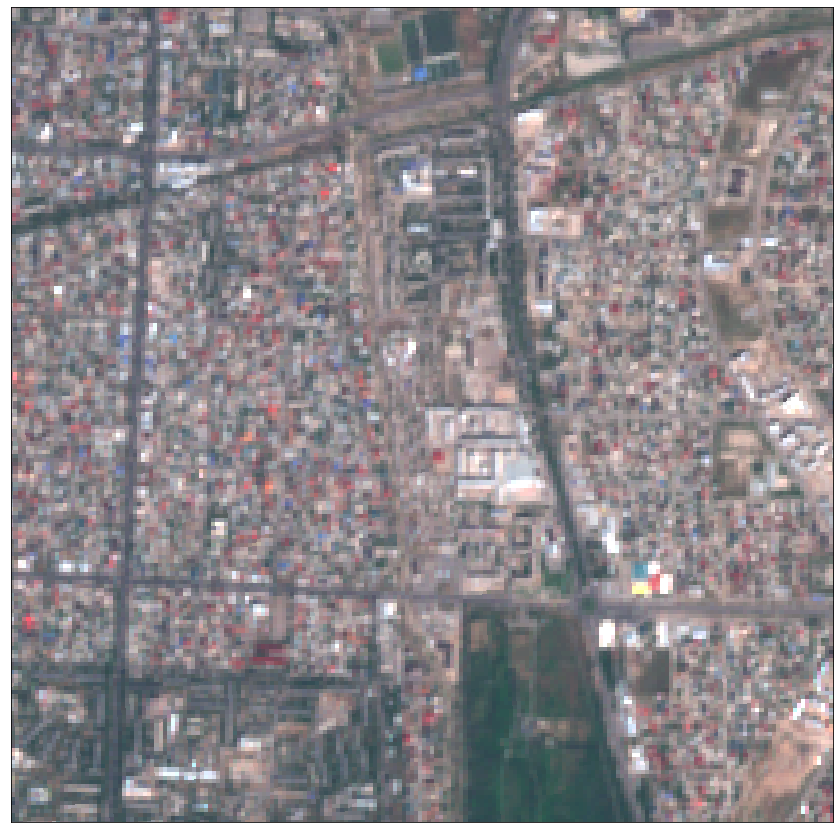

In [49]:
image = true_color_imgs[0]
print(f'Image type: {image.dtype}')

#plot function
#factor 1/255 to scale between 0-1
#factor 3.5 to increase brightness
plot_image(image, factor=3.5/255, clip_range=(0,1))

2. Using the previous function, write another function that, given a year and a lat-lon pair,
plots one image of the given location per every month of the year (12 images will be
plotted).

Test the functions with a corn field of your choice. You can find the location of agricultural fields
on OneSoil, for example

In [50]:
start_time = datetime.datetime(2020,1,1)
end_time = datetime.datetime(2020,12,31)
intervals = divide_time_into_intervals(start_time,end_time)

In [51]:
#Creating a list of requests
list_of_requests = [get_true_color_request(interval, selected_bbox, selected_size) for interval in intervals]
#Executing the requests
list_of_requests = [request.download_list[0] for request in list_of_requests]
#Downloading the date from the response
data = SentinelHubDownloadClient(config=config).download(list_of_requests, max_threads=5)

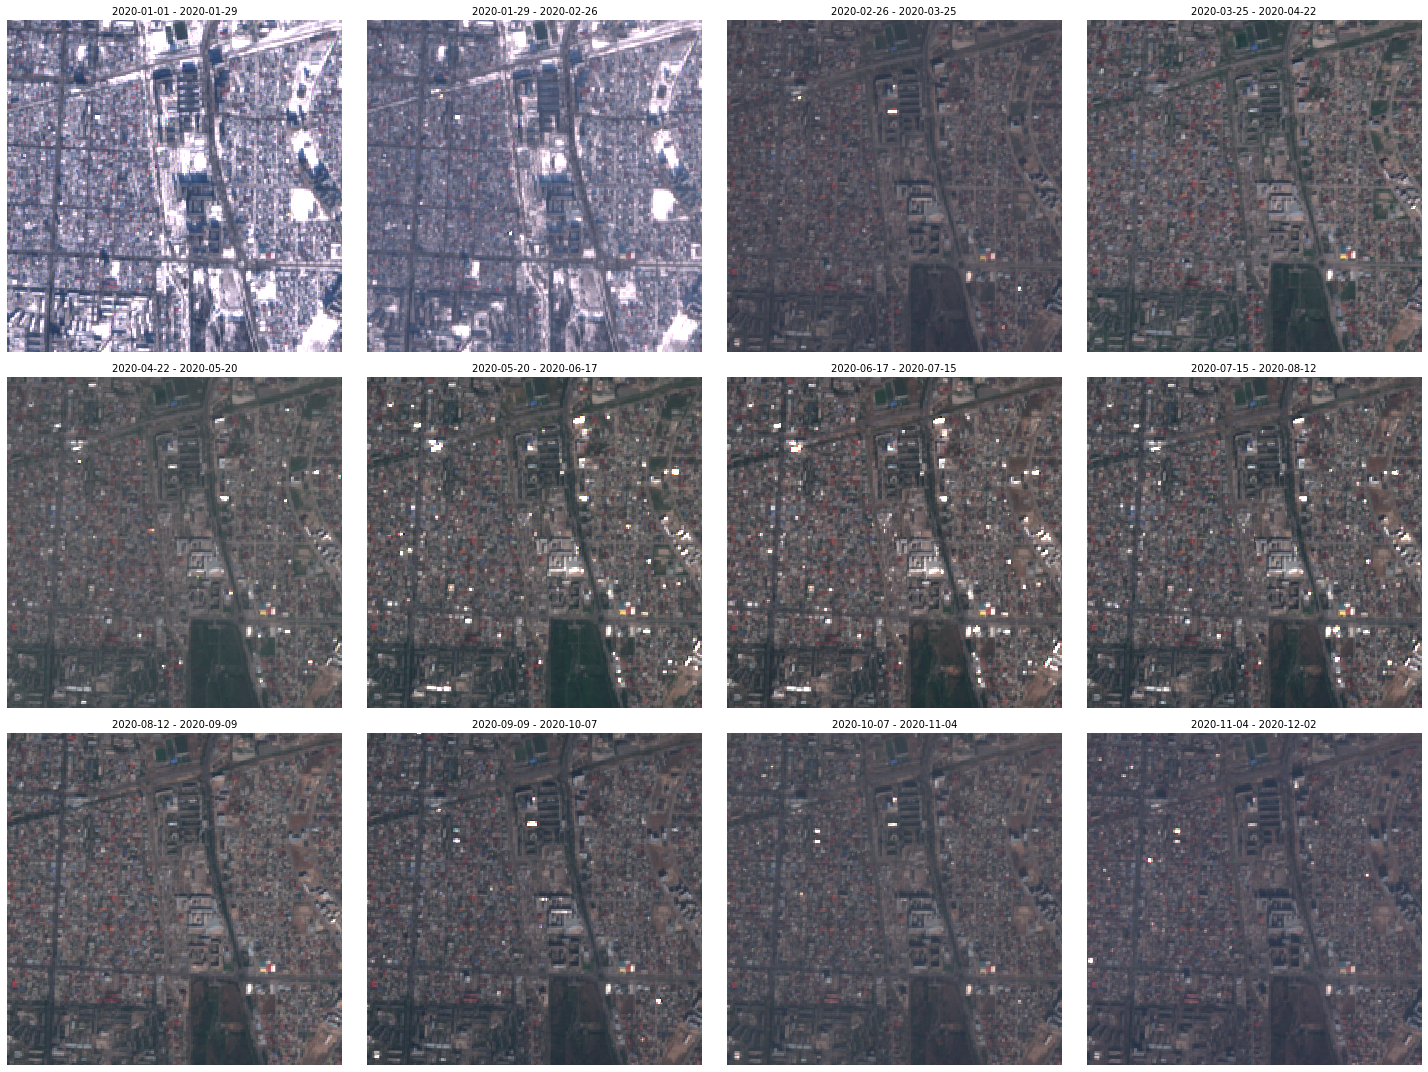

In [52]:
#Plotting the data
ncols = 4
nrows = 3
aspect_ratio = selected_size[0] / selected_size[1]
subplot_kw = {'xticks': [], 'yticks': [], 'frame_on': False}
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5 * ncols * aspect_ratio,5 * nrows), subplot_kw=subplot_kw)
for idx, image in enumerate(data):
    ax = axs[idx // ncols][idx % ncols]
    ax.imshow(np.clip(image * 2.5/255, 0, 1))
    ax.set_title(f'{intervals[idx][0]} - {intervals[idx][1]}', fontsize=10)
plt.tight_layout()